#  Прогнозирование заказов такси

Компания, предоставляющая услуги такси, собрала исторические данные о заказах такси в аэропортах. 

**Цель проекта:**

Спрогнозировать количество заказов такси на следующий час, для привлечения большего числа водителей в период пиковой нагрузки.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor, cv, Pool, train
from sklearn.model_selection import TimeSeriesSplit

In [2]:
def data_read(file):
    """
        Функция принемает путь к файлу, производит ресемплирование по часам, выводит на экран 10 сторк таблицы,
        информацию о столбцах, число дубликатов и возврашет таблицу типа DataFrame
    """
    data = pd.read_csv(file, index_col='datetime', 3)
    display(data.head(10))
    display(data.describe())
    data.info(memory_usage='deep')
    return data

In [3]:
df = data_read('/datasets/taxi.csv')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Критических ошибок в таблице не выявлено

In [4]:
df = df.resample('1H').sum()

## Анализ

Выделим из данных тренд, сезонность и остаток. Построим графики этих параметров за последний месяц.

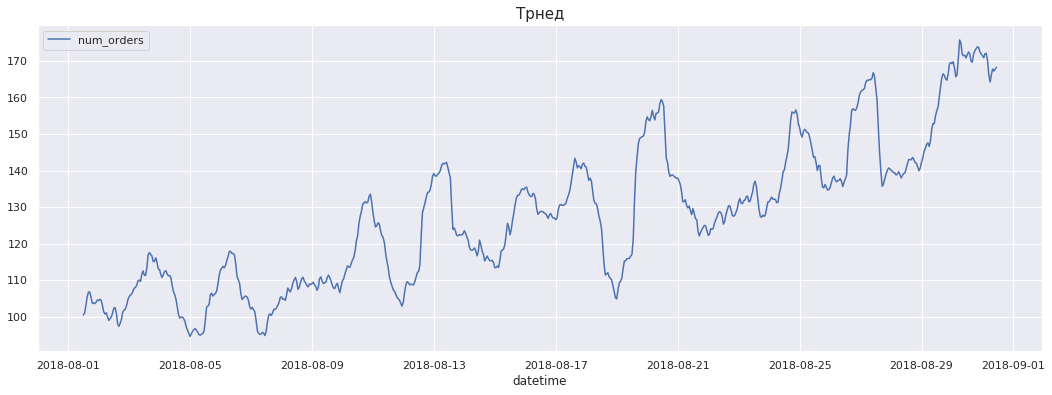

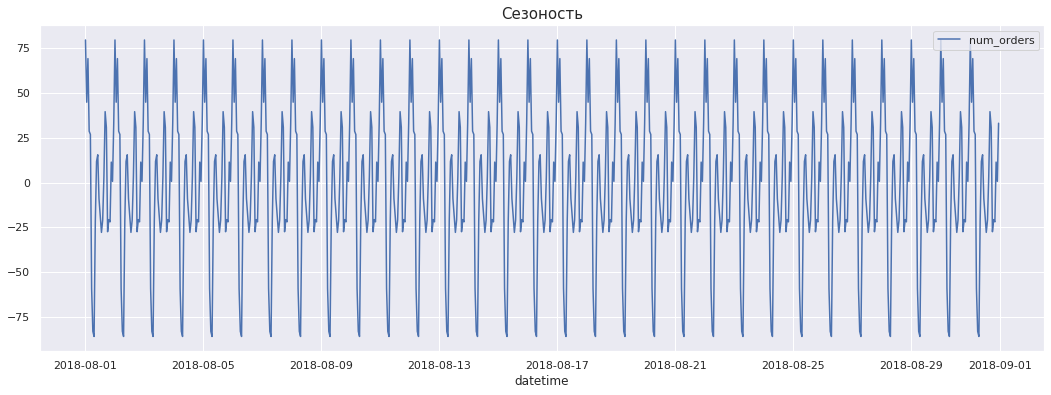

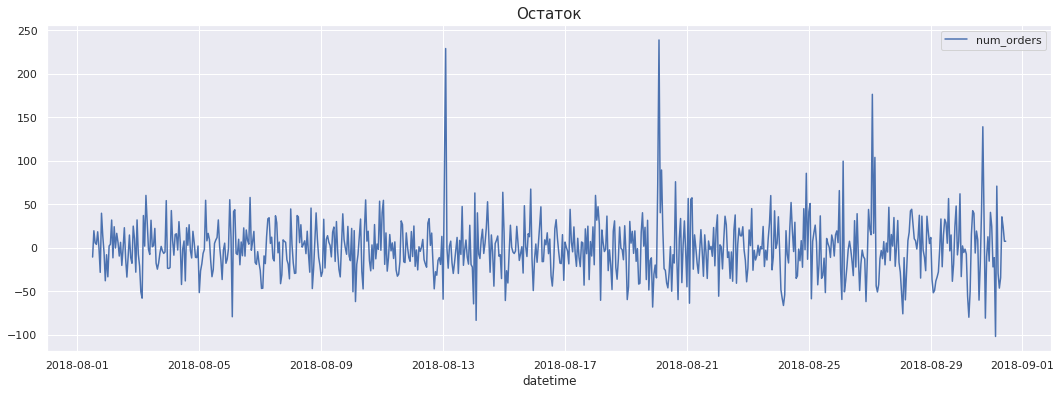

In [5]:
decomposed = seasonal_decompose(df['2018-08':'2018-09'])

trend = decomposed.trend
seasonal = decomposed.seasonal
resid = decomposed.resid

name = ['Трнед', 'Сезоность', 'Остаток']
row = 0
for i in [trend, seasonal, resid]:
    plt.figure(figsize=(18, 6))
    sns.set()
    sns.lineplot(data=i)
    plt.title(name[row], fontsize=15)
    row+=1
    plt.show()

1) График тренд показывает, что со временем спрос на такси увеличивается;

2) Амплитуда графика сезонности не изменяется. Также видно, что в ночное время число заказов минимально и максимально в вечернее время.


## Обучение

Создадим признаки и разделим данные

In [6]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(df, 24, 24)

In [7]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

features_train.shape, target_train.shape, features_test.shape, target_test.shape

((3950, 29), (3950,), (442, 29), (442,))

**Модель RandomForest**

In [8]:
rf_model = RandomForestRegressor()
parametrs = { 'n_estimators': [10, 20],
              'max_depth': [5, 10]}
grid = GridSearchCV(rf_model, parametrs, cv=TimeSeriesSplit(n_splits=8))
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 10, 'n_estimators': 20}

In [9]:
rf_model = RandomForestRegressor(random_state=12345, max_depth=10, n_estimators=20)
rf_model.fit(features_train, target_train)
predict = rf_model.predict(features_train)
rmse_rf_train = mse(target_train, predict)**0.5
print('RMSE обучающей выборки: {:.2f}'.format(rmse_rf_train))

RMSE обучающей выборки: 15.23


**Модель LinearRegression**

In [10]:
linear_model = LinearRegression()
parametrs = { 'normalize': ['False','bool'],
              'copy_X': ['True','bool']}
tscv = TimeSeriesSplit(n_splits=2).split(features_train)
grid = GridSearchCV(linear_model, parametrs, cv=tscv)
grid.fit(features_train, target_train)
grid.best_params_

{'copy_X': 'True', 'normalize': 'False'}

In [11]:
%%time
linear_model.fit(features_train, target_train)
predict = linear_model.predict(features_train)
rmse_lr_train = mse(target_train, predict)**0.5
print('RMSE обучающей выборки: {:.2f}'.format(rmse_lr_train))

RMSE обучающей выборки: 25.82
CPU times: user 110 ms, sys: 111 ms, total: 221 ms
Wall time: 288 ms


**Модель CatBoost**

In [12]:
cb_model = CatBoostRegressor(iterations=150, random_state=42, verbose=False)
parametrs = { 'max_depth': [1, 2],
              'bootstrap_type': ['Bayesian', 'MVS']}
tscv = TimeSeriesSplit(n_splits=2).split(features_train)
grid = GridSearchCV(cb_model, parametrs, cv=tscv)
grid.fit(features_train, target_train)
grid.best_params_

{'bootstrap_type': 'Bayesian', 'max_depth': 2}

In [13]:
%%time
catboost_model = CatBoostRegressor(iterations=150, max_depth=2, bootstrap_type='Bayesian',
                       random_state=42, verbose=150)
cb_model.fit(features_train, target_train)
predict = cb_model.predict(features_train)
rmse_cb_train = mse(target_train, predict)**0.5
print('RMSE обучающей выборки: {:.2f}'.format(rmse_cb_train))

RMSE обучающей выборки: 22.93
CPU times: user 5.34 s, sys: 673 ms, total: 6.01 s
Wall time: 7.17 s


**Вывод:**



In [14]:
d = ({'RMSE обучающей выборки':[rmse_rf_train, rmse_lr_train, rmse_cb_train]
      })
data = pd.DataFrame(data=d, index=['Randomforst','LinearRegression','CatBoost'])
data

,RMSE обучающей выборки
Randomforst,15.232433
LinearRegression,25.818602
CatBoost,22.932351


В данном пункте были построены модели Randomforst, LinearRegression и CatBoost. На основе лучших параметров моделей просчитаны RMSE обучающей выборки. Лучшей является модель Randomforst (RMSE: 15.12).

## Тестирование

**Модель Randomforest**

In [15]:
predict_rf = rf_model.predict(features_test)
rmse_rf_test = mse(target_test, predict_rf)**0.5
print('RMSE тестовой выборки:{:.2f}'.format(rmse_rf_test))

RMSE тестовой выборки:44.76


**Модель LenearRegression**

In [16]:
predict_lr = linear_model.predict(features_test)
rmse_lr_test = mse(target_test, predict_lr)**0.5
print('RMSE тестовой выборки:{:.2f}'.format(rmse_lr_test))

RMSE тестовой выборки:45.53


**Модель CatBoost**

In [17]:
predict_cb = cb_model.predict(features_test)
rmse_cb_test = mse(target_test, predict_cb)**0.5
print('RMSE тестовой выборки:{:.2f}'.format(rmse_cb_test))

RMSE тестовой выборки:48.04


Сравним значения целевого признака num_orders с предсказаними модели линейной регрессии и построим график по данным значениям за последние 5 дней.

In [18]:
predict_test = pd.Series(predict_lr, index = target_test.index, name='predict')
df_predict = pd.concat([target_test, predict_test], axis=1)
df_predict.head(10)

,num_orders,predict
datetime,,
2018-08-13 14:00:00,102,118.842078
2018-08-13 15:00:00,175,126.265668
2018-08-13 16:00:00,144,117.340179
2018-08-13 17:00:00,152,101.078806
2018-08-13 18:00:00,104,114.102160
2018-08-13 19:00:00,91,88.514200
2018-08-13 20:00:00,82,74.759161
2018-08-13 21:00:00,160,95.252643
2018-08-13 22:00:00,104,123.668334


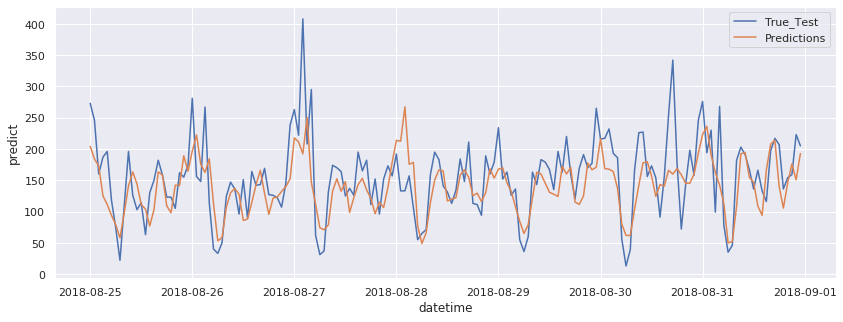

In [19]:
plt.figure(figsize=(14, 5))
data = df_predict['2018-08-25':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True_Test')
sns.lineplot(x=data.index, y=data['predict'], label='Predictions')

Видно, что график предсказаний схож с графиком реальных значений числа заказов такси, и лишь иногда предсказания сильно отличаются.

**Вывод:**



In [20]:
d = ({'RMSE тестовой выборки':[rmse_rf_test, rmse_lr_test, rmse_cb_test]
      })
data = pd.DataFrame(data=d, index=['Randomforst','LinearRegression','CatBoost'])
data

,RMSE тестовой выборки
Randomforst,44.761351
LinearRegression,45.529337
CatBoost,48.040821


В данном пункте были протестированы модели Randomforst, LinearRegression и CatBoost. RMSE всех моделей примерно одинаково и не превышает 48. Лучшей является модель Randomforst (RMSE: 45.13).

## Общий вывод

В ходе выполнения проекта были выполнены следующие шаги:

1) Загружены данные.

2) Проанализированы данные.

Построены графики тренда, сезонности и остатка.
        
3) Обучены модели Randomforst, LinearRegression и CatBoost и выявлены лучшие параметры.

4) Протестированы модели.

RMSE всех моделей примерно одинаково и не превышает 48. Лучшей является модель Randomforst (RMSE: 45.13).